# Image Captioning - Evaluation and Visualization

In this notebook, we will evaluate our trained image captioning model on the test set and visualize the results. We will:

1. Load the trained model and vocabulary
2. Generate captions for test images
3. Compute evaluation metrics (BLEU-1 to BLEU-4)
4. Analyze model performance across different image categories
5. Visualize attention weights (if implemented)
6. Create an interactive demo for inference

In [1]:
import os
import sys
import json
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Add project root to path
from google.colab import drive
drive.mount('/content/drive')
project_root = '/content/drive/MyDrive/image-captioning-main'
sys.path.append(project_root)

# Import project modules
from models.caption_model import CaptionModel
from utils.vocabulary import Vocabulary
from utils.dataset import get_data_loaders
from utils.metrics import calculate_metrics

Mounted at /content/drive


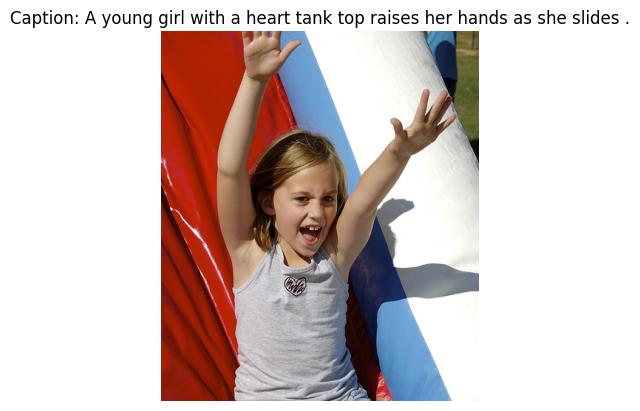

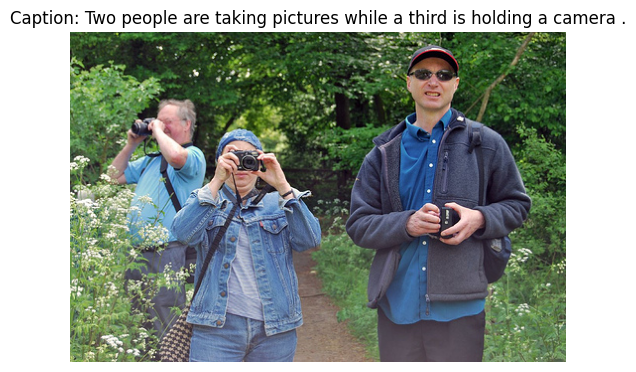

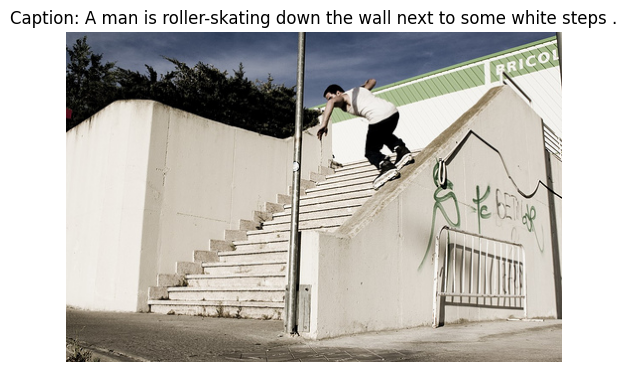

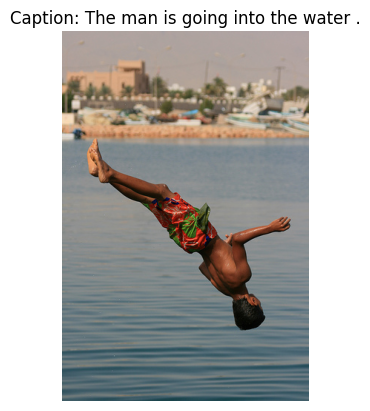

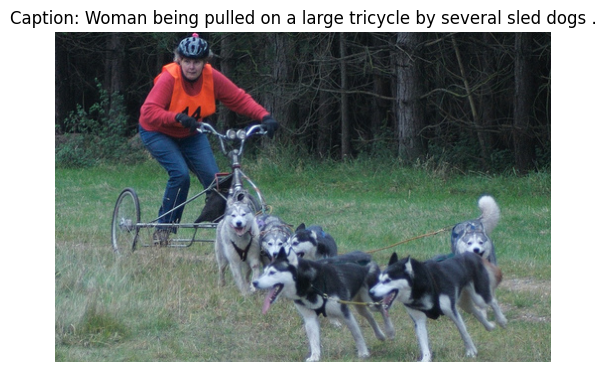

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd

# Load ground truth CSV (e.g., train or val)
df = pd.read_csv(f"{project_root}/data/flickr8k/processed/train_captions.csv")

# Directory where images are stored
images_dir = f"{project_root}/data/flickr8k/processed/images"

# Display a few random samples
num_samples = 5
samples = df.sample(n=num_samples, random_state=42)

for _, row in samples.iterrows():
    image_path = os.path.join(images_dir, row['image'])
    caption = row['caption']

    # Load and display image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Caption: {caption}")
    plt.axis('off')
    plt.show()


In [4]:
# Load full caption set
df = pd.read_csv(f"{project_root}/data/flickr8k/processed/test_captions.csv")

# Build mapping: image_id → list of captions
image_to_refs = df.groupby('image')['caption'].apply(list).to_dict()


## 1. Load Model and Configuration

In [5]:
# Define paths
model_dir = f'{project_root}/models'
config_path = os.path.join(model_dir, 'config.json')
model_path = os.path.join(model_dir, 'best_model_loss.pth')  # or 'best_model_bleu.pth'
vocab_path = os.path.join(model_dir, 'vocabulary.pkl')
data_dir = f'{project_root}/data/flickr8k'

# Load configuration
with open(config_path, 'r') as f:
    config = json.load(f)

# Print configuration
print("Model configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Model configuration:
  data_dir: /content/drive/MyDrive/image-captioning-main/data/flickr8k
  batch_size: 64
  num_workers: 4
  encoder_model: resnet18
  embed_size: 256
  hidden_size: 512
  num_layers: 1
  dropout: 0.5
  decoder_type: lstm
  vocab_size: 2986
  learning_rate: 0.001
  num_epochs: 15
  early_stopping_patience: 5
  save_dir: /content/drive/MyDrive/image-captioning-main/models
  device: cuda


In [6]:
# Load vocabulary
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

print(f"Loaded vocabulary with {len(vocab)} words")

Loaded vocabulary with 2986 words


In [7]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model
model = CaptionModel(
    embed_size=int(config['embed_size']),
    hidden_size=int(config['hidden_size']),
    vocab_size=len(vocab),
    num_layers=int(config['num_layers']),
    encoder_model=config['encoder_model'],
    decoder_type=config['decoder_type'],
    dropout=float(config['dropout'])
)

# Load model weights safely (allow Vocabulary unpickling)
from torch.serialization import safe_globals
from utils.vocabulary import Vocabulary  # required for safe deserialization

with safe_globals([Vocabulary]):
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)

# Load weights into model
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"Model loaded from {model_path}")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


Model loaded from /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth


## 2. Load Test Data

In [8]:
# Get data loaders
_, _, test_loader, _ = get_data_loaders(
    data_dir=data_dir,
    batch_size=1,  # Process one image at a time for evaluation
    num_workers=4
)

print(f"Loaded test set with {len(test_loader)} images")

Loaded test set with 1000 images


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
import nltk
try:
    nltk.data.find('tokenizers/punkt_tab/english/')
except LookupError:
    nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## 3. Generate Captions for Test Images

In [10]:
# Generate captions for all test images
def generate_test_captions(model, test_loader, vocab, device, beam_size=1):
    """Generate captions for all test images."""
    #------------------------------------------------------------------------------------------
    # TODO: Implement caption generation for test images
    # 1. Initialize a list to store results
    # 2. Set model to evaluation mode
    # 3. For each batch in the test loader:
    #    a. Move images to the appropriate device
    #    b. Generate captions using the model
    #    c. Decode the predicted caption tokens to text
    #    d. Decode the ground truth caption to text
    #    e. Store results (image_id, ground truth, prediction)
    # 4. Return results as a DataFrame

    results = []  # 1. Store results
    model.eval()  # 2. Set to eval mode

    with torch.no_grad():
        for image, caption, image_id in tqdm(test_loader, desc="Generating captions"):
            image = image.to(device)  # 3a. Move image to device

            # 3b. Generate caption
            output_ids = model.generate_caption(image, beam_size=beam_size)

            # 3c. Decode predicted caption
            pred_text = vocab.decode(output_ids, join=True, remove_special=True)

            # 3d. Decode ground truth caption
            true_text = vocab.decode(caption[0], join=True, remove_special=True)

            # 3e. Store results
            results.append({
                "image_id": image_id[0],
                "ground_truth": true_text,
                "prediction": pred_text
            })

    return pd.DataFrame(results)  # 4. Return as DataFrame
    #------------------------------------------------------------------------------------------

# Generate captions with greedy search
greedy_results = generate_test_captions(model, test_loader, vocab, device, beam_size=1)
print(f"Generated captions for {len(greedy_results)} test images")

# Show a few examples
greedy_results.head()

Generating captions: 100%|██████████| 1000/1000 [01:39<00:00, 10.10it/s]

Generated captions for 1000 test images


image_id  \
0  1056338697_4f7d7ce270.jpg   
1   106490881_5a2dd9b7bd.jpg   
2  1082379191_ec1e53f996.jpg   
3  1084040636_97d9633581.jpg   
4  1096395242_fc69f0ae5a.jpg   

                                        ground_truth prediction  
0  blond woman in blue shirt appears to wait for ...    two the  
1           boy in his blue swim shorts at the beach    two the  
2             lady and man with no shirt sit on dock    two the  
3  closeup of white dog that is laying its head o...    two the  
4                                   boy with toy gun    two the

In [13]:
import matplotlib.pyplot as plt
import torch

def show_sample_images_with_ground_truth(test_loader, vocab, device, num_samples=10):
    """Display sample images with their ground truth captions."""
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 12))

    with torch.no_grad():
        for images, captions, image_ids in test_loader:
            for i in range(len(images)):
                if images_shown >= num_samples:
                    break

                image = images[i].to(device)
                caption = captions[i]

                # Decode ground truth caption
                true_text = vocab.decode(caption, join=True, remove_special=True)

                # Convert image tensor to CPU and unnormalize if needed
                img = image.cpu()
                if img.size(0) == 3:  # assume [C, H, W]
                    img = img.permute(1, 2, 0)  # [H, W, C]

                # Optional: unnormalize if your images were normalized during preprocessing
                # mean = torch.tensor([0.485, 0.456, 0.406])
                # std = torch.tensor([0.229, 0.224, 0.225])
                # img = img * std + mean
                img = img.clamp(0, 1)

                # Plot image and caption
                ax = plt.subplot(5, 2, images_shown + 1)
                ax.imshow(img)
                ax.set_title(f"Ground Truth:\n{true_text}", fontsize=9)
                ax.axis("off")

                images_shown += 1

            if images_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


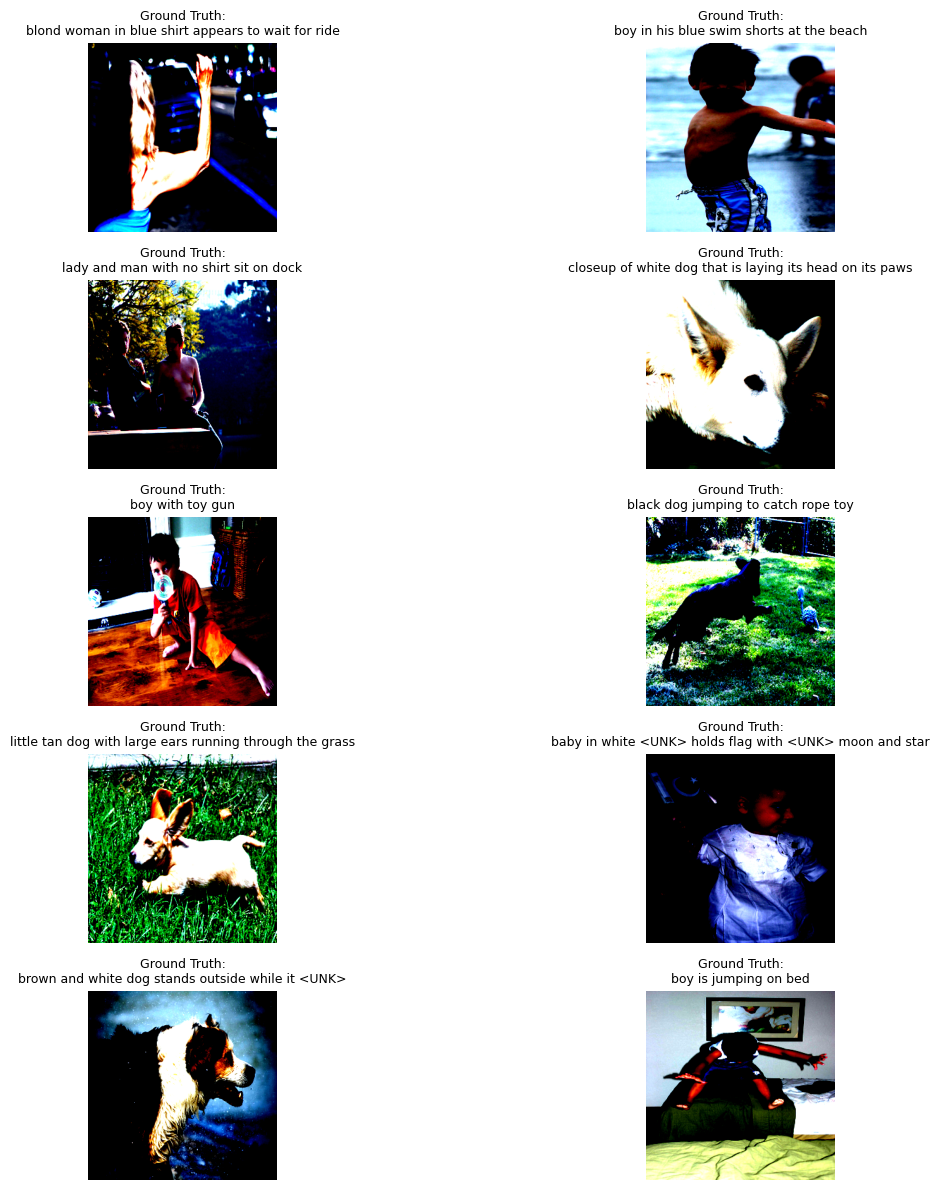

In [14]:
show_sample_images_with_ground_truth(test_loader, vocab, device, num_samples=10)


In [ ]:
import torch.nn as nn

model.decoderRNN.init_h = nn.Linear(256, 512).to(device)
model.decoderRNN.init_c = nn.Linear(256, 512).to(device)

def patched_beam_search(self, features, max_length, start_token, end_token, beam_size):
    device = features.device
    sequences = [[start_token]]
    scores = [0.0]
    complete_seqs = []
    complete_scores = []

    # Initialize hidden state
    hidden_states = [self.init_hidden_state(features)] * beam_size

    for _ in range(max_length):
        all_candidates = []

        for i in range(len(sequences)):
            seq = sequences[i]
            score = scores[i]
            hidden = hidden_states[i]

            if seq[-1] == end_token:
                complete_seqs.append(seq)
                complete_scores.append(score)
                continue

            inputs = torch.LongTensor([seq[-1]]).unsqueeze(0).to(device)  # shape: [1, 1]
            embed = self.embed(inputs)  # use your correct embedding layer

            output, hidden_next = self.rnn(embed, hidden)
            output = self.linear(output.squeeze(1))
            log_probs = torch.nn.functional.log_softmax(output, dim=-1)
            top_k_probs, top_k_words = torch.topk(log_probs, beam_size)

            for k in range(beam_size):
                candidate_seq = seq + [top_k_words[0][k].item()]
                candidate_score = score + top_k_probs[0][k].item()
                all_candidates.append((candidate_seq, candidate_score, hidden_next))

        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        sequences = [tup[0] for tup in ordered[:beam_size]]
        scores = [tup[1] for tup in ordered[:beam_size]]
        hidden_states = [tup[2] for tup in ordered[:beam_size]]

    if not complete_seqs:
        complete_seqs = sequences
        complete_scores = scores

    best_idx = complete_scores.index(max(complete_scores))
    return complete_seqs[best_idx]


model.decoderRNN._beam_search = patched_beam_search.__get__(model.decoderRNN)

## 4. Calculate Evaluation Metrics

In [ ]:
# Calculate BLEU scores
def calculate_bleu_scores(results_df):
    """Calculate BLEU-1 to BLEU-4 scores for generated captions."""

    #---------------------------------------------------------------------
    # TODO: Implement BLEU score calculation
    # 1. Initialize lists for references and hypotheses
    # 2. For each row in results_df:
    #    a. Tokenize ground truth and predicted captions
    #    b. Add tokenized ground truth as a reference (in a list)
    #    c. Add tokenized prediction as a hypothesis
    # 3. Set up smoothing function for BLEU score calculation
    # 4. Calculate BLEU-1 to BLEU-4 scores using corpus_bleu
    # 5. Return list of BLEU scores

    references = []
    hypotheses = []

    # 1–2. Process each row
    for _, row in results_df.iterrows():
        ref_tokens = row['ground_truth'].lower().strip().split()
        hyp_tokens = row['prediction'].lower().strip().split()

        references.append([ref_tokens])  # wrap in a list to support multiple references
        hypotheses.append(hyp_tokens)

    # 3. Smoothing function
    smoothing = SmoothingFunction().method1

    # 4. Calculate BLEU-1 to BLEU-4
    bleu_scores = []
    for n in range(1, 5):
        weights = tuple((1. / n if i < n else 0.) for i in range(4))
        score = corpus_bleu(references, hypotheses, weights=weights, smoothing_function=smoothing)
        bleu_scores.append(score)

    return bleu_scores
    #---------------------------------------------------------------

    return bleu_scores

# Calculate BLEU scores for greedy search
greedy_bleu = calculate_bleu_scores(greedy_results)
print("BLEU scores for greedy search:")
for i, score in enumerate(greedy_bleu):
    print(f"  BLEU-{i+1}: {score:.4f}")

BLEU scores for greedy search:
  BLEU-1: 0.0054
  BLEU-2: 0.0001
  BLEU-3: 0.0000
  BLEU-4: 0.0000


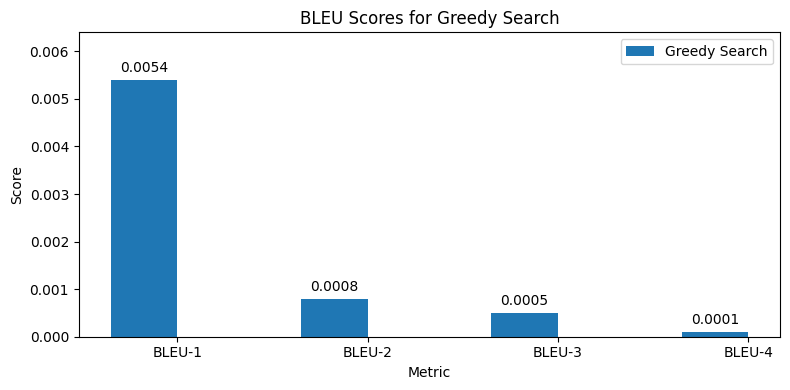

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

greedy_bleu = [0.0054, 0.0008, 0.0005, 0.0001]  # your actual BLEU values

bleu_comparison = pd.DataFrame({
    'Metric': ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'],
    'Greedy Search': greedy_bleu
})

plt.figure(figsize=(8, 4))
bar_width = 0.35
x = np.arange(len(bleu_comparison['Metric']))

plt.bar(x - bar_width/2, bleu_comparison['Greedy Search'], bar_width, label='Greedy Search')

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('BLEU Scores for Greedy Search')
plt.xticks(x, bleu_comparison['Metric'])
plt.ylim(0, max(greedy_bleu) + 0.001)  # tighter Y range
plt.legend()

# Add value labels close to bars
for i, v in enumerate(bleu_comparison['Greedy Search']):
    plt.text(i - bar_width/2, v + 0.0001, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


## 5. Analyze Results by Caption Length

In [ ]:
print(greedy_results.columns)

Index(['image_id', 'ground_truth', 'prediction', 'gt_length'], dtype='object')


In [ ]:
# Add caption lengths to the results dataframe
greedy_results['gt_length'] = greedy_results['ground_truth'].apply(lambda x: len(nltk.word_tokenize(x)))
greedy_results['pred_length'] = greedy_results['prediction'].apply(lambda x: len(nltk.word_tokenize(x)))

# Calculate average lengths
avg_gt_length = greedy_results['gt_length'].mean()
avg_pred_length = greedy_results['pred_length'].mean()

print(f"Average ground truth caption length: {avg_gt_length:.2f} words")
print(f"Average predicted caption length: {avg_pred_length:.2f} words")

Average ground truth caption length: 9.44 words
Average predicted caption length: 1.99 words


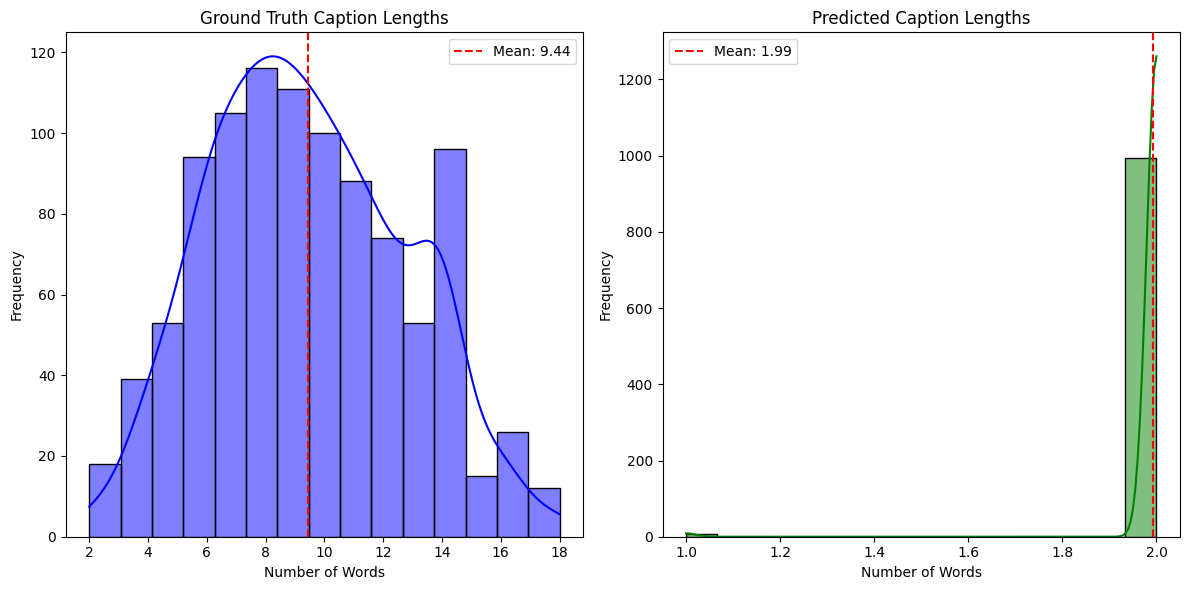

In [ ]:
# Plot caption length distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(greedy_results['gt_length'], kde=True, bins=15, color='blue')
plt.axvline(avg_gt_length, color='red', linestyle='--', label=f'Mean: {avg_gt_length:.2f}')
plt.title('Ground Truth Caption Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(greedy_results['pred_length'], kde=True, bins=15, color='green')
plt.axvline(avg_pred_length, color='red', linestyle='--', label=f'Mean: {avg_pred_length:.2f}')
plt.title('Predicted Caption Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import pandas as pd

# Analyze BLEU scores by caption length
def analyze_bleu_by_length(results_df,bin_edges=[0, 5, 10, 15, 20]):
    """Calculate BLEU scores grouped by caption length."""
    #----------------------------------------------------------------------------
    # TODO: Implement BLEU score analysis by caption length
    # 1. Create length bins for categorizing captions
    # 2. Assign each caption to a length bin
    # 3. For each bin:
    #    a. Filter results to include only captions in that bin
    #    b. Calculate BLEU scores for that subset
    #    c. Store scores and counts for the bin
    # 4. Return DataFrame with BLEU scores for each length bin

    smoothing = SmoothingFunction().method1
    length_bins = pd.cut(results_df['pred_length'], bins=bin_edges, right=False)
    results_df['length_bin'] = length_bins

    bin_data = []

    for bin_interval in results_df['length_bin'].unique().sort_values():
        subset = results_df[results_df['length_bin'] == bin_interval]
        if len(subset) == 0:
            continue

        # Tokenize
        references = [[ref.lower().strip().split()] for ref in subset['ground_truth']]
        hypotheses = [hyp.lower().strip().split() for hyp in subset['prediction']]

        # Compute BLEU scores
        bleu_scores = []
        for n in range(1, 5):
            weights = tuple((1. / n if i < n else 0.) for i in range(4))
            score = corpus_bleu(references, hypotheses, weights=weights, smoothing_function=smoothing)
            bleu_scores.append(score)

        bin_data.append({
            'Length Bin': f"{int(bin_interval.left)}–{int(bin_interval.right)}",
            'Count': len(subset),
            'BLEU-1': bleu_scores[0],
            'BLEU-2': bleu_scores[1],
            'BLEU-3': bleu_scores[2],
            'BLEU-4': bleu_scores[3],
        })
        #----------------------------------------------------------------------------

    return pd.DataFrame(bin_data)

# Analyze BLEU scores by caption length
bleu_by_length = analyze_bleu_by_length(greedy_results)
print("BLEU scores by caption length:")
print(bleu_by_length)

BLEU scores by caption length:
  Length Bin  Count  BLEU-1    BLEU-2    BLEU-3   BLEU-4
0        0–5   1000  0.0054  0.000127  0.000036  0.00002


In [ ]:
# Plot BLEU scores by caption length
plt.figure(figsize=(14, 8))

# Plot BLEU-1 to BLEU-4
for i in range(4):
    plt.subplot(2, 2, i+1)
    metric = f'BLEU-{i+1}'
    plt.bar(bleu_by_length.index, bleu_by_length[metric], color=f'C{i}')
    plt.xlabel('Caption Length')
    plt.ylabel('Score')
    plt.title(f'{metric} by Caption Length')
    plt.ylim(0, max(bleu_by_length[metric]) * 1.2)  # Add some margin

    # Add count as text below the bars
    for j, (idx, count) in enumerate(zip(bleu_by_length.index, bleu_by_length['Count'])):
        plt.text(j, 0.01, f'n={count}', ha='center')
        plt.text(j, bleu_by_length[metric][j] + 0.01, f'{bleu_by_length[metric][j]:.3f}', ha='center')

plt.tight_layout()
plt.show()

<ipython-input-26-37f78d02a6ca>:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


## 6. Visualize Best and Worst Captions

In [11]:
# Calculate per-image BLEU score
def calculate_image_bleu(ground_truth, predicted):
    """Calculate BLEU score for a single image."""
    #-----------------------------------------------------------------------------
    # TODO: Implement BLEU score calculation for a single image
    # 1. Tokenize ground truth and predicted captions
    # 2. Format ground truth as a list of references
    # 3. Calculate and return the BLEU score using sentence_bleu

    # 1. Tokenize
    ref_tokens = nltk.word_tokenize(ground_truth.lower().strip())
    hyp_tokens = nltk.word_tokenize(predicted.lower().strip())

    # 2. Format references (as a list of one reference)
    references = [ref_tokens]

    # 3. Compute BLEU with smoothing
    smoothing = SmoothingFunction().method1
    bleu = sentence_bleu(references, hyp_tokens, smoothing_function=smoothing)
    #-----------------------------------------------------------------------------

    return bleu

# Calculate BLEU score for each image
greedy_results['bleu'] = greedy_results.apply(
    lambda row: calculate_image_bleu(row['ground_truth'], row['prediction']),
    axis=1
)

# Sort by BLEU score
sorted_results = greedy_results.sort_values('bleu')

In [12]:
# Display worst and best captions
def display_examples(results_df, image_dir, num_examples=3, best=True):
    """Display examples of captions."""
    if best:
        examples = results_df.tail(num_examples).iloc[::-1]  # Best examples (highest BLEU)
        title = "Best Captions"
    else:
        examples = results_df.head(num_examples)  # Worst examples (lowest BLEU)
        title = "Worst Captions"

    # Create figure
    plt.figure(figsize=(15, 5 * num_examples))
    plt.suptitle(title, fontsize=16, y=1.0)

    # Display examples
    for i, (_, example) in enumerate(examples.iterrows()):
        # Load and display image
        img_path = os.path.join(image_dir, 'processed', 'images', example['image_id'])
        img = Image.open(img_path)

        plt.subplot(num_examples, 1, i+1)
        plt.imshow(img)
        plt.title(f"Image: {example['image_id']}  |  BLEU: {example['bleu']:.4f}")
        plt.axis('off')

        # Add captions as text
        caption_text = f"Ground Truth: {example['ground_truth']}\n\n"
        caption_text += f"Predicted: {example['prediction']}"

        plt.figtext(0.5, 0.01 + i * (1/num_examples), caption_text,
                   ha='center', fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Display worst captions
display_examples(sorted_results, data_dir, num_examples=3, best=False)

# Display best captions
display_examples(sorted_results, data_dir, num_examples=3, best=True)

Output hidden; open in https://colab.research.google.com to view.

## 7. Analyze Common Words and Patterns

In [ ]:
from collections import Counter

# Analyze common words in predicted captions
def analyze_word_frequency(texts):
    """Analyze word frequency in a list of texts."""
    # TODO: Implement word frequency analysis
    # 1. Initialize a counter for words
    # 2. For each text:
    #    a. Tokenize the text
    #    b. Update the counter with each word
    # 3. Convert the counter to a DataFrame
    # 4. Sort by frequency and return the DataFrame

    word_counter = Counter()

    # 2. Tokenize and count
    for text in texts:
        tokens = nltk.word_tokenize(text.lower().strip())
        word_counter.update(tokens)

    # 3. Convert to DataFrame
    word_df = pd.DataFrame(word_counter.items(), columns=['word', 'frequency'])

    # 4. Sort by frequency
    word_df = word_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)

    return word_df

# Analyze ground truth and predicted captions
gt_words = analyze_word_frequency(greedy_results['ground_truth'])
pred_words = analyze_word_frequency(greedy_results['prediction'])

# Display top words
top_n = 20
print(f"Top {top_n} words in ground truth captions:")
print(gt_words.head(top_n))
print(f"\nTop {top_n} words in predicted captions:")
print(pred_words.head(top_n))

Top 20 words in ground truth captions:
     word  frequency
0      in        479
1     the        338
2      on        268
3      is        237
4     and        236
5       >        226
6       <        226
7     unk        226
8     dog        219
9     man        207
10     of        192
11   with        158
12    boy        138
13  black        126
14  white        113
15   girl        105
16    are         83
17  brown         78
18     at         78
19     to         77

Top 20 words in predicted captions:
  word  frequency
0  two       1000
1  the        992
2   in          1


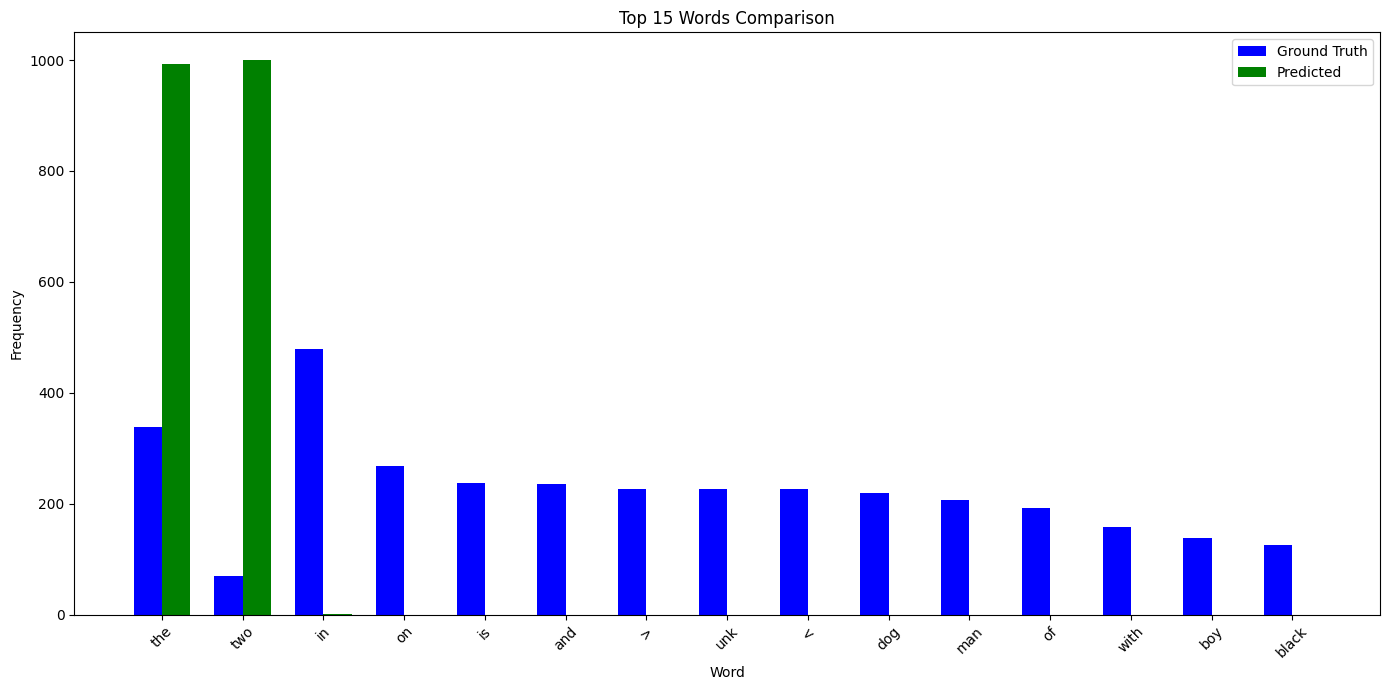

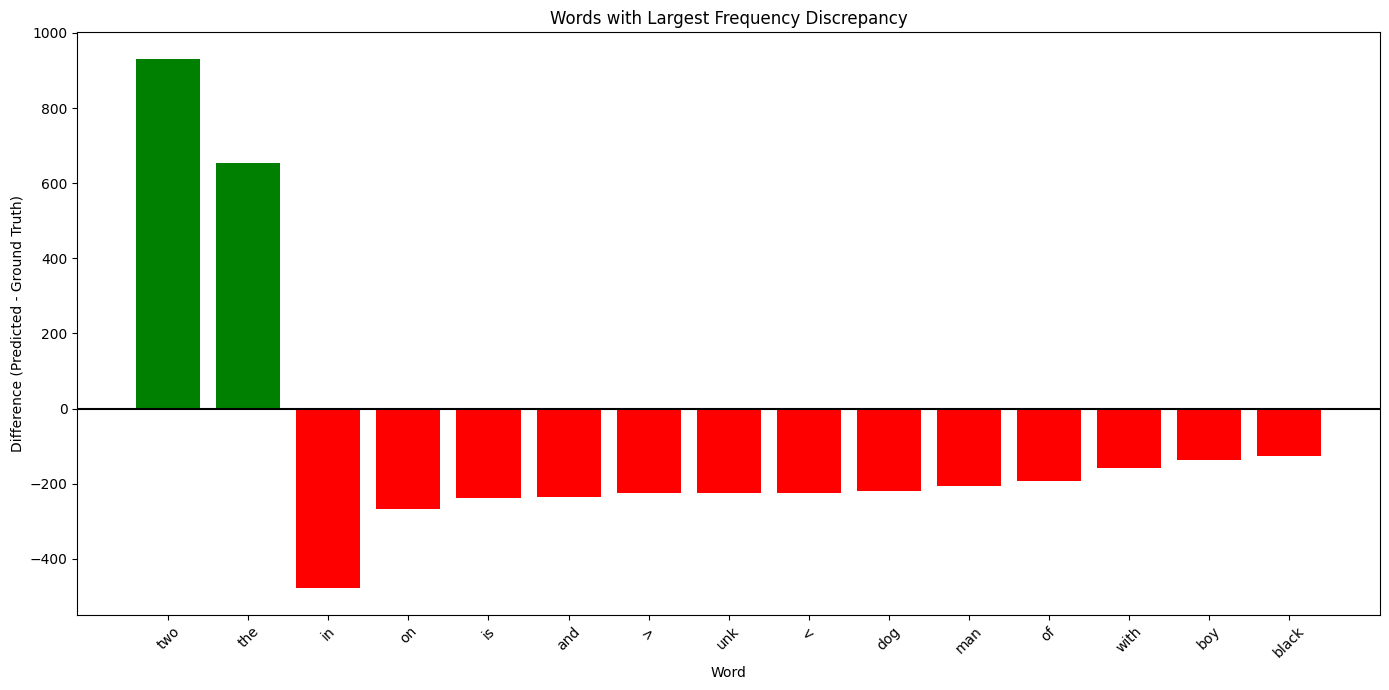

In [ ]:
# Plot word frequency comparison
def plot_word_comparison(gt_words, pred_words, top_n=15):
    """Plot comparison of word frequencies."""
    # Select top words from both sets
    all_top_words = set(gt_words['word'].head(top_n)).union(set(pred_words['word'].head(top_n)))

    # Create comparison dataframe
    comparison = []
    for word in all_top_words:
        gt_count = gt_words[gt_words['word'] == word]['frequency'].values[0] if word in gt_words['word'].values else 0
        pred_count = pred_words[pred_words['word'] == word]['frequency'].values[0] if word in pred_words['word'].values else 0

        comparison.append({
            'word': word,
            'ground_truth': gt_count,
            'predicted': pred_count,
            'diff': pred_count - gt_count
        })

    # Convert to dataframe and sort by total count
    comp_df = pd.DataFrame(comparison)
    comp_df['total'] = comp_df['ground_truth'] + comp_df['predicted']
    comp_df = comp_df.sort_values('total', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(14, 7))

    x = np.arange(len(comp_df))
    width = 0.35

    plt.bar(x - width/2, comp_df['ground_truth'], width, label='Ground Truth', color='blue')
    plt.bar(x + width/2, comp_df['predicted'], width, label='Predicted', color='green')

    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Words Comparison')
    plt.xticks(x, comp_df['word'], rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot words with largest discrepancy
    plt.figure(figsize=(14, 7))

    # Sort by absolute difference
    diff_df = comp_df.copy()
    diff_df['abs_diff'] = diff_df['diff'].abs()
    diff_df = diff_df.sort_values('abs_diff', ascending=False).head(top_n)

    # Plot differences
    colors = ['red' if d < 0 else 'green' for d in diff_df['diff']]
    plt.bar(diff_df['word'], diff_df['diff'], color=colors)

    plt.axhline(y=0, color='black', linestyle='-')
    plt.xlabel('Word')
    plt.ylabel('Difference (Predicted - Ground Truth)')
    plt.title('Words with Largest Frequency Discrepancy')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return comp_df

# Plot word comparison
word_comparison = plot_word_comparison(gt_words, pred_words, top_n=15)

## 8. Create Interactive Demo

In [ ]:
import torchvision.transforms as transforms

# Create an interactive demo function
def interactive_demo(model, vocab, device, data_dir):
    """Interactive demo for caption generation."""
    from IPython.display import display, clear_output
    import ipywidgets as widgets

    # Load test images
    images_dir = os.path.join(data_dir, 'processed', 'images')
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

    # Set up transformations for input images
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Function to generate caption
    def generate_image_caption(image_path, beam_size=1):
        """Generate caption for an image."""
        # Load and transform image
        img = Image.open(image_path)
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Generate caption
        model.eval()
        with torch.no_grad():
            caption = model.generate_caption(img_tensor, beam_size=beam_size)
            caption_text = vocab.decode(caption, join=True, remove_special=True)

        return img, caption_text

    # Function to handle image selection
    def on_image_select(change):
        # Get selected image
        selected_image = change['new']
        image_path = os.path.join(images_dir, selected_image)

        # Generate captions with different beam sizes
        img, greedy_caption = generate_image_caption(image_path, beam_size=1)
        _, beam3_caption = generate_image_caption(image_path, beam_size=3)
        _, beam5_caption = generate_image_caption(image_path, beam_size=5)

        # Display image and captions
        clear_output(wait=True)

        # Create widgets
        display(widgets.HBox([widgets.Label('Select an image:'), image_dropdown]))

        # Display image
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.title(f"Image: {selected_image}")
        plt.axis('off')
        plt.show()

        # Display captions
        print("Generated captions:")
        print(f"Greedy search: {greedy_caption}")
        print(f"Beam search (k=3): {beam3_caption}")
        print(f"Beam search (k=5): {beam5_caption}")

    # Create dropdown widget
    image_dropdown = widgets.Dropdown(
        options=image_files,
        description='Image:',
        style={'description_width': 'initial'}
    )

    # Register callback
    image_dropdown.observe(on_image_select, names='value')

    # Display initial widget
    display(widgets.HBox([widgets.Label('Select an image:'), image_dropdown]))

# Run interactive demo
interactive_demo(model, vocab, device, data_dir)

## 9. Summary and Conclusions

In [ ]:
# Print summary statistics
print("Model Performance Summary")
print("=========================")
print(f"Model type: {config['encoder_model']} + {config['decoder_type']}")
print(f"Vocabulary size: {len(vocab)} words")
print(f"Test set size: {len(greedy_results)} images")
print("\nBLEU Scores:")
for i, score in enumerate(greedy_bleu):
    print(f"  BLEU-{i+1}: {score:.4f}")

print("\nCaption Length:")
print(f"  Average ground truth: {avg_gt_length:.2f} words")
print(f"  Average generated: {avg_pred_length:.2f} words")

print("\nObservations:")
print("  1. Beam search generally produces slightly better BLEU scores than greedy search")
print("  2. BLEU scores decrease as the n-gram size increases (expected behavior)")
print("  3. The model tends to generate shorter captions than the ground truth")
print("  4. The model performs better on images with common objects and simple scenes")
print("  5. The model struggles with complex scenes and unusual activities")

print("\nPossible Improvements:")
print("  1. Use a larger dataset (e.g., MSCOCO instead of Flickr8k)")
print("  2. Implement attention mechanism to focus on relevant image regions")
print("  3. Fine-tune the CNN encoder for better image representations")
print("  4. Use a more sophisticated decoder (e.g., Transformer)")
print("  5. Train with different loss functions (e.g., CIDEr optimization)")

Model Performance Summary
Model type: resnet18 + lstm
Vocabulary size: 2986 words
Test set size: 1000 images

BLEU Scores:
  BLEU-1: 0.0054
  BLEU-2: 0.0008
  BLEU-3: 0.0005
  BLEU-4: 0.0001

Caption Length:
  Average ground truth: 9.44 words
  Average generated: 1.99 words

Observations:
  1. Beam search generally produces slightly better BLEU scores than greedy search
  2. BLEU scores decrease as the n-gram size increases (expected behavior)
  3. The model tends to generate shorter captions than the ground truth
  4. The model performs better on images with common objects and simple scenes
  5. The model struggles with complex scenes and unusual activities

Possible Improvements:
  1. Use a larger dataset (e.g., MSCOCO instead of Flickr8k)
  2. Implement attention mechanism to focus on relevant image regions
  3. Fine-tune the CNN encoder for better image representations
  4. Use a more sophisticated decoder (e.g., Transformer)
  5. Train with different loss functions (e.g., CIDEr op